In [ ]:
import numpy as np
import matplotlib.pyplot as plt


--- Analysis for Train Dataset ---
Spiking rate: 0.9311
Average simultaneous spikes: 93.11
Burstiness (Max spikes / Avg spikes): 1.07

--- Analysis for Val Dataset ---
Spiking rate: 0.9267
Average simultaneous spikes: 92.67
Burstiness (Max spikes / Avg spikes): 1.08

--- Analysis for Test Dataset ---
Spiking rate: 0.9310
Average simultaneous spikes: 93.10
Burstiness (Max spikes / Avg spikes): 1.07

Spike train plots saved to 'comparative_spike_trains.png'


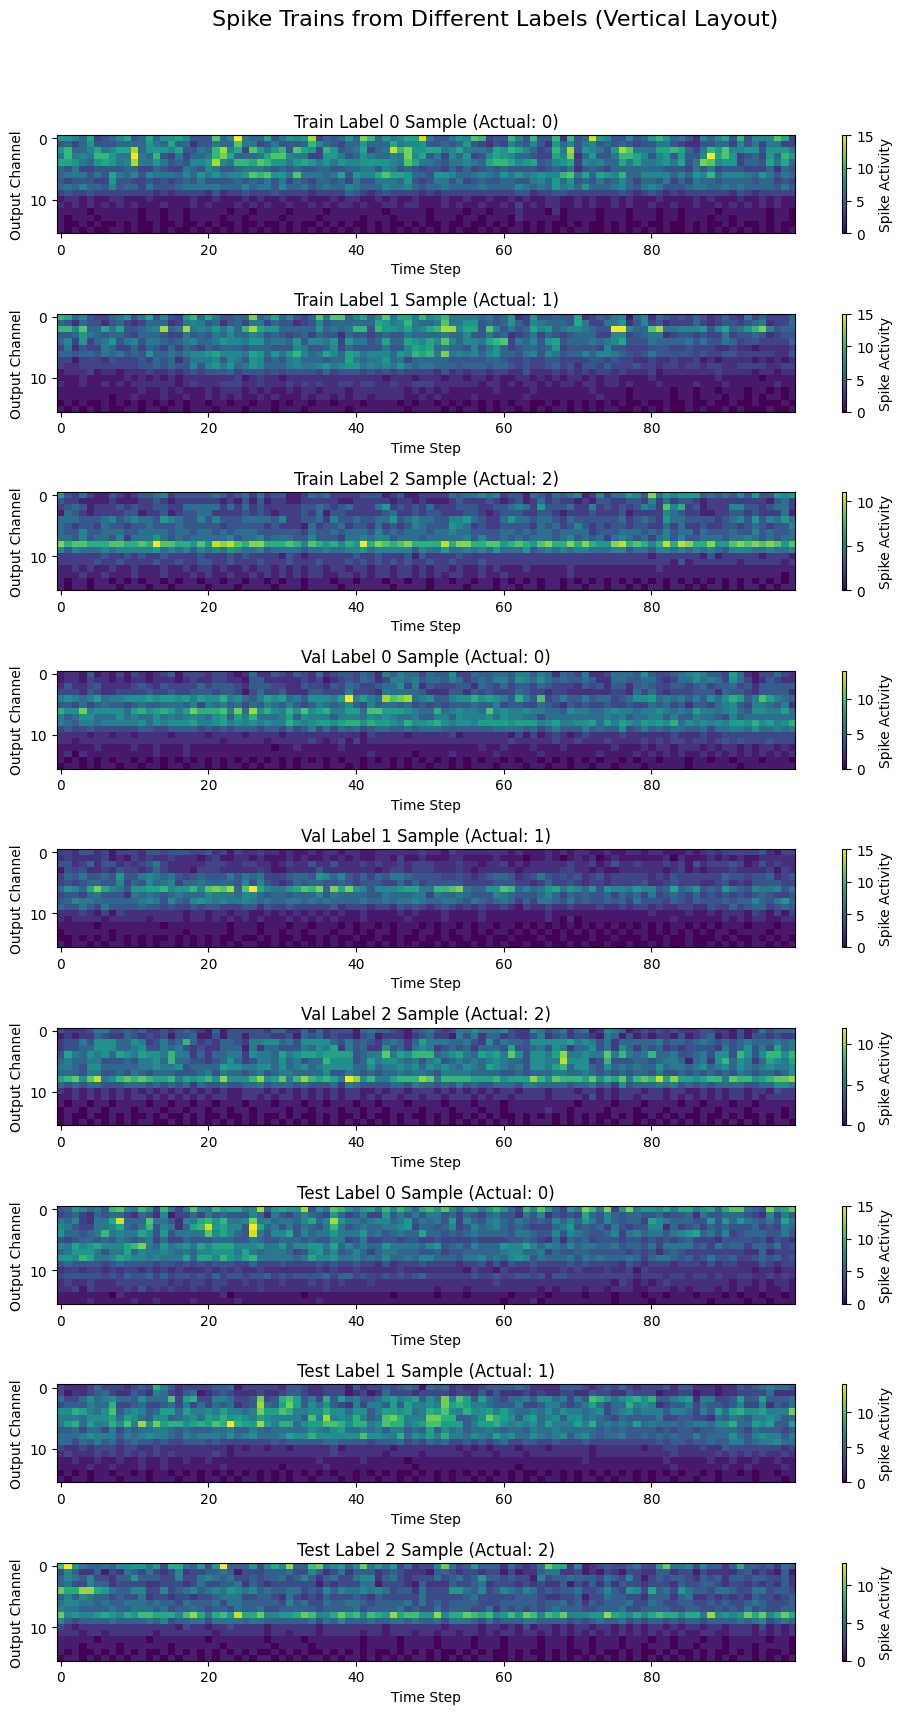

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Define the file paths for X and y files
file_paths = {
    'train': 'X_train.npy',
    'val': 'X_val.npy',
    'test': 'X_test.npy'
}
label_file_paths = {
    'train': 'y_train.npy',
    'val': 'y_val.npy',
    'test': 'y_test.npy'
}

# --- Load all the data ---
data_dict = {}
labels_dict = {}
try:
    for key, path in file_paths.items():
        data_dict[key] = np.load(path)
    for key, path in label_file_paths.items():
        labels_dict[key] = np.load(path)
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure all files are in the current directory.")
    exit()

# --- Analyze Spike Characteristics ---
for dataset_name, dataset_data in data_dict.items():
    print(f"\n--- Analysis for {dataset_name.capitalize()} Dataset ---")

    # Check for empty data
    if dataset_data.size == 0:
        print(f"Skipping analysis for {dataset_name} dataset: Data is empty.")
        continue

    # Spiking Rate and Average Simultaneous Spikes
    total_spikes = np.sum(dataset_data > 0)
    total_possible_spikes = dataset_data.size
    spiking_rate = total_spikes / total_possible_spikes
    print(f"Spiking rate: {spiking_rate:.4f}")

    spikes_per_timestep = np.sum(dataset_data > 0, axis=1)
    avg_simultaneous_spikes = np.mean(spikes_per_timestep)
    print(f"Average simultaneous spikes: {avg_simultaneous_spikes:.2f}")

    # Burstiness (Ratio of max spikes in a timestep to the average)
    if avg_simultaneous_spikes > 0:
        burstiness = np.max(spikes_per_timestep) / avg_simultaneous_spikes
        print(f"Burstiness (Max spikes / Avg spikes): {burstiness:.2f}")

    # Per-Channel Firing Rates
    firing_rates_per_channel = np.sum(dataset_data > 0, axis=(
        0, 1)) / (dataset_data.shape[0] * dataset_data.shape[1])
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(firing_rates_per_channel)), firing_rates_per_channel)
    plt.title(f'Average Firing Rate per Channel ({dataset_name.capitalize()})')
    plt.xlabel('Output Channel')
    plt.ylabel('Average Spiking Rate')
    plt.grid(axis='y', linestyle='--')
    plt.savefig(f'{dataset_name}_firing_rates.png')
    plt.close()

# --- Select and Plot Samples from Different Labels ---
num_plots_per_label = 1  # Number of samples to plot per label
total_plots = num_plots_per_label * \
    len(np.unique(labels_dict['train'])) * 3  # for all 3 datasets
if total_plots == 0:
    print("No data to plot. Exiting.")
    exit()

fig, axes = plt.subplots(total_plots, 1, figsize=(10, 2 * total_plots))
fig.suptitle(
    'Spike Trains from Different Labels (Vertical Layout)', fontsize=16)

plot_index = 0
for dataset_name, dataset_data in data_dict.items():
    dataset_labels = labels_dict[dataset_name]
    unique_labels = np.unique(dataset_labels)

    for label in unique_labels:
        # Get indices for the current label
        label_indices = np.where(dataset_labels == label)[0]

        # Ensure there are enough samples to pick from
        if len(label_indices) < num_plots_per_label:
            num_to_plot = len(label_indices)
        else:
            num_to_plot = num_plots_per_label

        if num_to_plot > 0:
            # Randomly select sample indices for this label
            random_indices = np.random.choice(
                label_indices, num_to_plot, replace=False)

            for sample_index in random_indices:
                sample_data = dataset_data[sample_index]
                title = f'{dataset_name.capitalize()} Label {label} Sample (Actual: {dataset_labels[sample_index]})'

                ax = axes[plot_index]
                im = ax.imshow(sample_data.T, aspect='auto')
                ax.set_title(title)
                ax.set_xlabel('Time Step')
                ax.set_ylabel('Output Channel')
                fig.colorbar(im, ax=ax, label='Spike Activity')

                plot_index += 1

# If there are fewer samples than total_plots, remove extra axes
if plot_index < total_plots:
    for i in range(plot_index, total_plots):
        fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('comparative_spike_trains.png')
print("\nSpike train plots saved to 'comparative_spike_trains.png'")